# Overview of the data of the project

In [1]:
from cmath import isnan

## import packages
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns


# Train and test data

In [2]:
df_train = pd.read_csv(os.path.join("..", "data", "raw", "train.csv"), low_memory=False)
df_test = pd.read_csv(os.path.join("..", "data", "raw", "test.csv"), low_memory=False)

# Compare the columns of the train and test data

Show the columns which are in the training data but not in the test data

In [3]:
set(df_train.columns) - set(df_test.columns)
print(f'Columns in train but not in test: {list(set(df_train.columns) - set(df_test.columns))}')

Columns in train but not in test: ['bg+1:00']


We can say taht train and test data have the same columns and the only difference is the target column 'bg+1:00' in the training data.

## Data structure (columns)

The data consists of the following columns:
- id: unique identifier for each data point starting with patient number (p_num) followed by an ascending integer (e.g. p01_1, p01_2, p01_3, ...)
- p_num: patient number (e.g. p01, p02, ...)
- time: time (without date) of the data point in format 'HH:MM:SS'
- bg: blood glucose reading in mmol/L over the last 6 hours from 'time'-column in 5 minute intervals (bg-0:00 to bg-5:55) 
- insulin: total insulin dose received in units in the last 6 hours from 'time'-column in 5 minute intervals (insulin-0:00 to insulin-5:55) 
- carbs: total carbohydrate value consumed in grammes in the last 6 hours from 'time'-column in 5 minute intervals (carbs-0:00 to carbs-5:55)
- hr: mean heart rate in beats per minute in the last 6 hours from 'time'-column in 5 minute intervals (hr-0:00 to hr-5:55)
- steps: total steps walked in the last 6 hours from 'time'-column in 5 minute intervals (steps-0:00 to steps-5:55)
- cals: total calories burnt in the last 6 hours from 'time'-column in 5 minute intervals (cals-0:00 to cals-5:55)
- activity: self-declared activity performed in the last 6 hours from 'time'-column in 5 minute intervals (activity-0:00 to activity-5:55)



In [4]:
df_train.head()

,id,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
0,p01_0,p01,06:10:00,NaN,NaN,9.6,NaN,NaN,9.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.4
1,p01_1,p01,06:25:00,NaN,NaN,9.7,NaN,NaN,9.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.8
2,p01_2,p01,06:40:00,NaN,NaN,9.2,NaN,NaN,8.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.5
3,p01_3,p01,06:55:00,NaN,NaN,8.7,NaN,NaN,8.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.8
4,p01_4,p01,07:10:00,NaN,NaN,8.4,NaN,NaN,8.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.7


## Patient data

How many patients are in the training and test data?


In [5]:
print(f'Number of patients in training data: {len(df_train["p_num"].unique())}')
print(f'Number of patients in test data: {len(df_test["p_num"].unique())}')

Number of patients in training data: 9
Number of patients in test data: 15




## How many datapoints are in the training and test data?

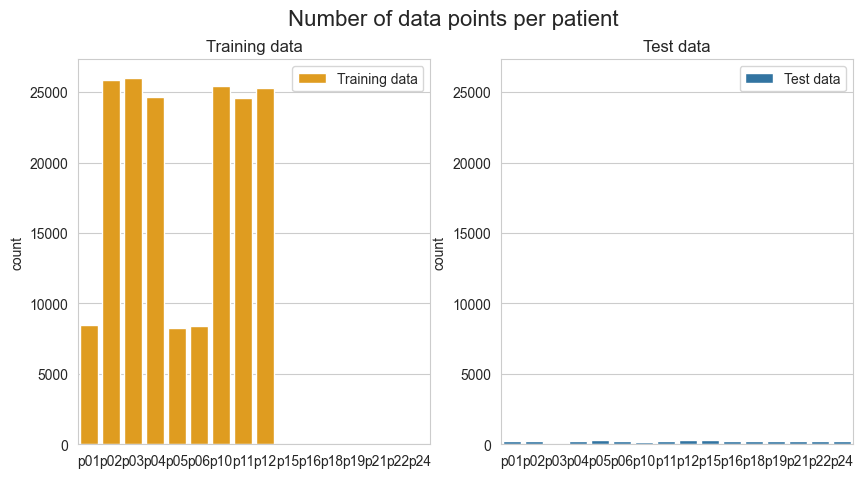

In [6]:
patient_list = sorted(list(set(df_train["p_num"].unique()) | set(df_test["p_num"].unique())))
train_counts = df_train["p_num"].value_counts().reindex(patient_list, fill_value=0)
test_counts = df_test["p_num"].value_counts().reindex(patient_list, fill_value=0)

fig = plt.figure(figsize=(10, 5))
fig.suptitle("Number of data points per patient", fontsize=16)
ax1 = fig.add_subplot(1, 2, 1)
sns.barplot(x=patient_list, y=train_counts, label="Training data", color="orange")
ax1.set_title("Training data")

ax2 = fig.add_subplot(1, 2, 2)
sns.barplot(x=patient_list, y=test_counts, label="Test data")
ax2.set_title("Test data")

# Find the maximum y-axis limit between both plots
y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])

# Set the same y-axis limit for both plots
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, y_max)

plt.show();

## Patient 01 Data

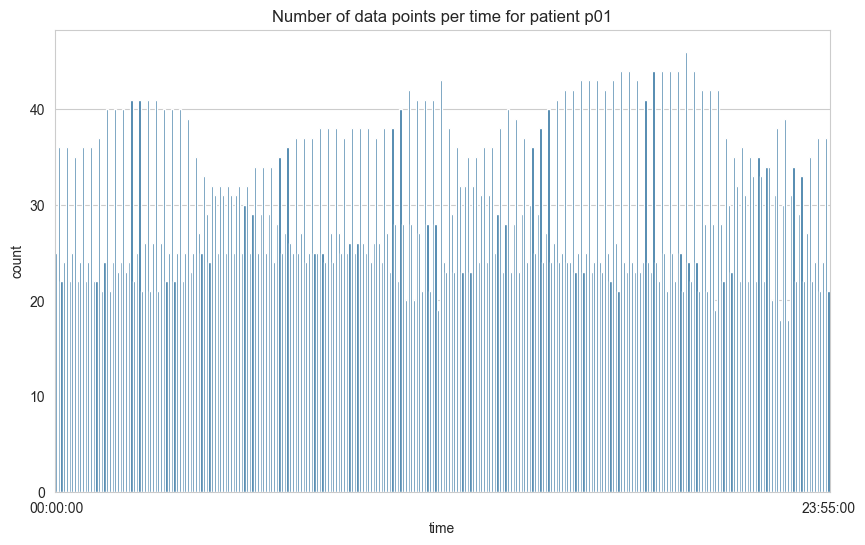

In [7]:
# get data from the first patient
df_train_p01 = df_train[df_train["p_num"] == "p01"].sort_values("time")

plt.figure(figsize=(10, 6))
ax = sns.countplot(x="time", data=df_train_p01)
ax.set_title("Number of data points per time for patient p01")

# Customize x-ticks to show only the first and last
ticks = ax.get_xticks()
tick_labels = ax.get_xticklabels()

ax.set_xticks(ticks[::len(ticks) - 1])
ax.set_xticklabels(tick_labels[::len(ticks) - 1])

plt.show();

In [8]:
# add a date and date time column with an invented start date

from datetime import datetime, timedelta

df_train_p01 = df_train_p01.sort_index()
df_train_p01.loc[:, "time"] = pd.to_datetime(df_train_p01["time"], format="%H:%M:%S").dt.time

start_date = datetime(2020, 1, 1)
current_date = start_date
assigned_dates = []

for i, row in df_train_p01.iterrows():
    if row["time"] < df_train_p01["time"].iloc[i - 1]:
        current_date = current_date + timedelta(days=1)
    assigned_dates.append(current_date)
    
df_train_p01.loc[:, "date"] = assigned_dates
df_train_p01.loc[:, "datetime"] = df_train_p01.apply(lambda row: datetime.combine(row['date'], row['time']), axis=1)
df_train_p01[["time", "date", "datetime"]].head()

,time,date,datetime
0,06:10:00,2020-01-02,2020-01-02 06:10:00
1,06:25:00,2020-01-02,2020-01-02 06:25:00
2,06:40:00,2020-01-02,2020-01-02 06:40:00
3,06:55:00,2020-01-02,2020-01-02 06:55:00
4,07:10:00,2020-01-02,2020-01-02 07:10:00


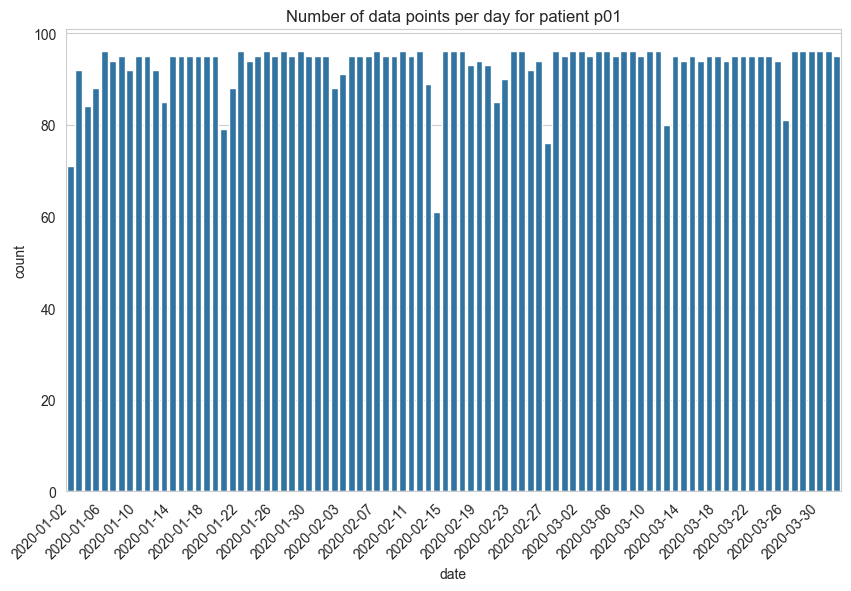

In [9]:
# show number of data points per day
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="date", data=df_train_p01)
ax.set_title("Number of data points per day for patient p01")

# Get the current x-tick labels
ticks = ax.get_xticks()
tick_labels = ax.get_xticklabels()

# Set every second label to an empty string (you can modify the interval if needed)
new_labels = [label.get_text() if i % 4 == 0 else '' for i, label in enumerate(tick_labels)]

# Apply the new x-tick labels
ax.set_xticks(ticks)
ax.set_xticklabels(new_labels, rotation=45, ha="right")

plt.show();

In [10]:
df_train_p01["bg-0:00"].isna().sum()

np.int64(743)

In [11]:
df_train_p01.loc[:, "bg"] = df_train_p01.apply(lambda row: row["bg-0:00"] if not np.isnan(row["bg-0:00"]) else row["bg-0:00"], axis=1)
df_train_p01[["datetime", "bg"]].head()

,datetime,bg
0,2020-01-02 06:10:00,15.1
1,2020-01-02 06:25:00,14.4
2,2020-01-02 06:40:00,13.9
3,2020-01-02 06:55:00,13.8
4,2020-01-02 07:10:00,13.4


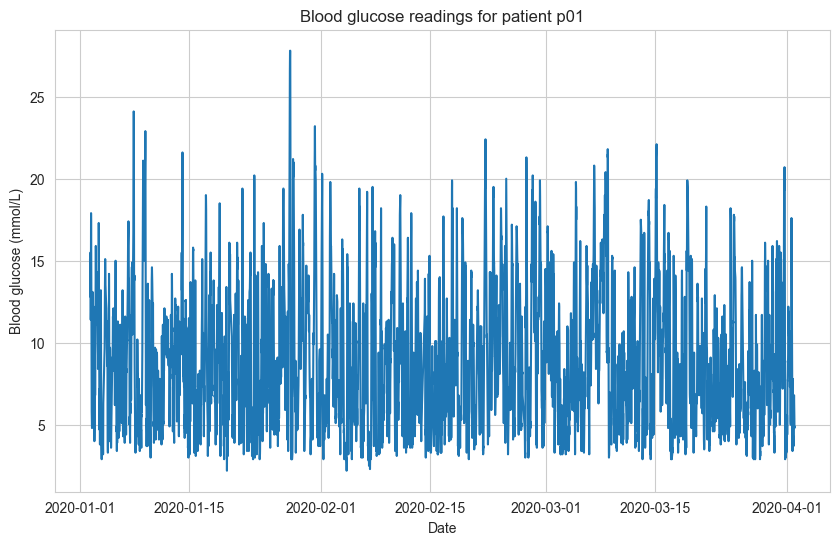

In [12]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x="datetime", y="bg", data=df_train_p01)
ax.set_title("Blood glucose readings for patient p01")
ax.set_ylabel("Blood glucose (mmol/L)")
ax.set_xlabel("Date")
plt.show();

 ## Patient 02 Data

In [13]:
# get data from the first patient
df_train_p02 = df_train[df_train["p_num"] == "p02"].sort_index()

df_train_p02.loc[:, "time"] = pd.to_datetime(df_train_p02["time"], format="%H:%M:%S").dt.time

start_date = datetime(2020, 1, 1)
current_date = start_date
assigned_dates = []

for i in range(len(df_train_p02)):
    if df_train_p02['time'].iloc[i] < df_train_p02["time"].iloc[i - 1]:
        current_date = current_date + timedelta(days=1)
    assigned_dates.append(current_date)
df_train_p02.loc[:, "date"] = assigned_dates
df_train_p02.loc[:, "datetime"] = df_train_p02.apply(lambda row: datetime.combine(row['date'], row['time']), axis=1)
df_train_p02[["time", "date", "datetime"]].head()

,time,date,datetime
8459,06:05:00,2020-01-02,2020-01-02 06:05:00
8460,06:10:00,2020-01-02,2020-01-02 06:10:00
8461,06:15:00,2020-01-02,2020-01-02 06:15:00
8462,06:20:00,2020-01-02,2020-01-02 06:20:00
8463,06:25:00,2020-01-02,2020-01-02 06:25:00


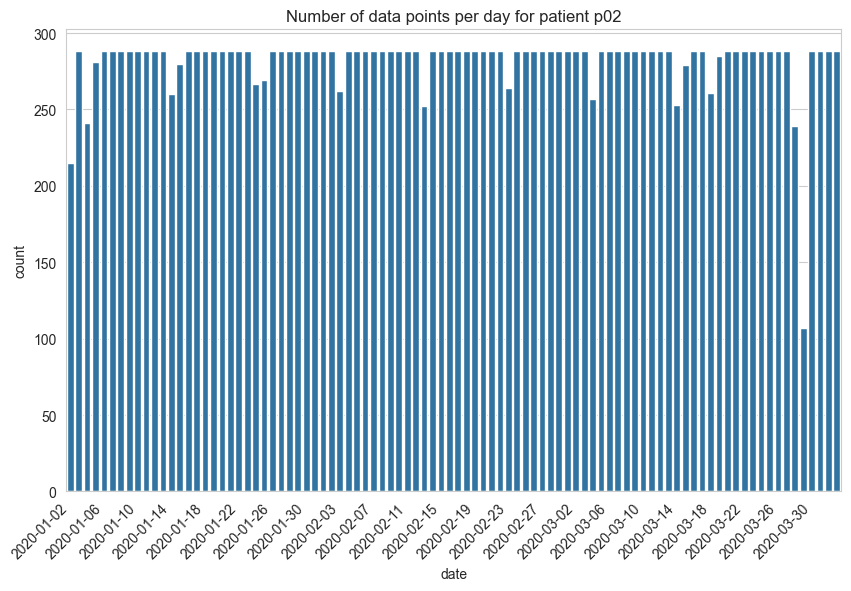

In [14]:
# show number of data points per day
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="date", data=df_train_p02)
ax.set_title("Number of data points per day for patient p02")

# Get the current x-tick labels
ticks = ax.get_xticks()
tick_labels = ax.get_xticklabels()

# Set every second label to an empty string (you can modify the interval if needed)
new_labels = [label.get_text() if i % 4 == 0 else '' for i, label in enumerate(tick_labels)]

# Apply the new x-tick labels
ax.set_xticks(ticks)
ax.set_xticklabels(new_labels, rotation=45, ha="right")

plt.show();


In [15]:
df_train_p02.loc[:, "bg"] = df_train_p02.apply(lambda row: row["bg-0:00"] if not np.isnan(row["bg-0:00"]) else row["bg-0:00"], axis=1)
df_train_p02[["datetime", "bg"]].head()

,datetime,bg
8459,2020-01-02 06:05:00,6.7
8460,2020-01-02 06:10:00,6.5
8461,2020-01-02 06:15:00,6.5
8462,2020-01-02 06:20:00,6.5
8463,2020-01-02 06:25:00,6.5


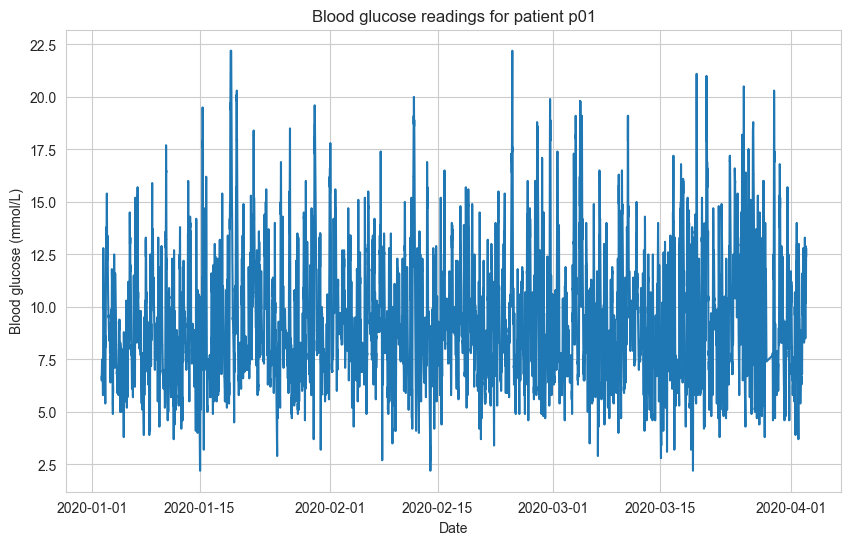

In [16]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x="datetime", y="bg", data=df_train_p02)
ax.set_title("Blood glucose readings for patient p01")
ax.set_ylabel("Blood glucose (mmol/L)")
ax.set_xlabel("Date")
plt.show();

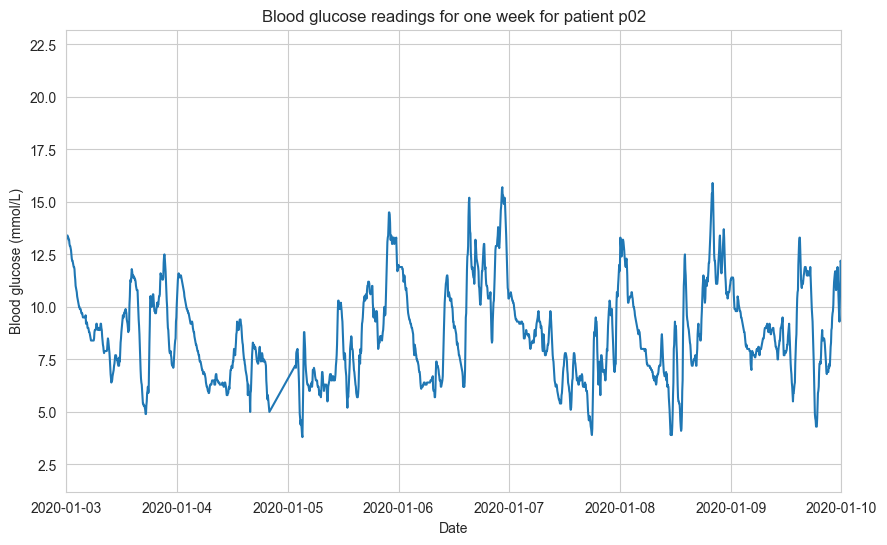

In [17]:
# show bg for one 1 week
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x="datetime", y="bg", data=df_train_p02)
ax.set_title("Blood glucose readings for one week for patient p02")
ax.set_ylabel("Blood glucose (mmol/L)")
ax.set_xlabel("Date")
ax.set_xlim(datetime(2020, 1, 3), datetime(2020, 1, 10))
plt.show();


## Conclusion about different patient types

We see different amount of data points per day for different patients. Some patients three times more data points than others.  
Patient 1, 5, 6 are low data poit patients, one data point per 15 minutes.  
Patient 2, 3, 4, 10, 11, 12 are high data point patients, one data point per 5 minutes.


# Next steps

* merge data values
* fill missing values
* data exploration
    * different patient types
    * different measurement devices
    * different insulin types
    * correlation between patient data   
* 